# 1. Dependency libraries

In [1]:
from model.seg_hrnet import seg_hrnet
from utils.loss import *
from utils.metrics import *
from dataloaders.generater import *
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
from keras.utils.training_utils import multi_gpu_model

Using TensorFlow backend.


# 2. Params

In [2]:
# network params
BatchSize = 8
NumChannels = 3
ImgHeight = 512
ImgWidth = 512
NumClass = 1

# training params
GPUs = '0, 1, 2, 3'
os.environ["CUDA_VISIBLE_DEVICES"] = GPUs
Optimizer = 'Adam'  # SGD(lr=0.01, momentum=0.9, nesterov=True)
Loss = ce_jaccard_loss
Metrics = ['accuracy', iou]
NumEpochs = 100
Patience = 10

# data params
TrainImageDir = '/data/dh_zhu/cong/AerialImageDataset/train/images/'
ValImageDir = '/data/dh_zhu/cong/AerialImageDataset/val/images/'

# visualization params
metric_list = ['acc', 'iou']

In [3]:
model = seg_hrnet(BatchSize, ImgHeight, ImgWidth, NumChannels, NumClass)
model.summary()
# model.load_weights('seg_hrnet-08-4.2117-0.9428-0.4832.hdf5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (8, 512, 512, 3)     0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (8, 256, 256, 64)    1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (8, 256, 256, 64)    256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (8, 256, 256, 64)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [4]:
class ParallelModelCheckpoint(ModelCheckpoint):
    def __init__(self,model,filepath, monitor='val_loss', verbose=0,
                 save_best_only=False, save_weights_only=False,
                 mode='auto', period=1):
        self.single_model = model
        super(ParallelModelCheckpoint,self).__init__(filepath, monitor, verbose,save_best_only, save_weights_only,mode, period)

    def set_model(self, model):
        super(ParallelModelCheckpoint,self).set_model(self.single_model)

In [5]:
paralle_model = multi_gpu_model(model, gpus=4)
paralle_model.compile(optimizer=Optimizer, loss=Loss, metrics=Metrics)
model_path = "seg_hrnet-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}-{val_iou:.4f}.hdf5"
model_checkpoint = ParallelModelCheckpoint(model, model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=False)
# model_checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=False)

In [6]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=Patience)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=2)
check_point_list = [model_checkpoint, early_stop, reduce_lr]

In [7]:
train_paths, val_paths = get_data_paths(TrainImageDir, ValImageDir)
train_steps = len(train_paths) // BatchSize
val_steps = len(val_paths) // BatchSize

In [8]:
result = paralle_model.fit_generator(
    generator=batch_generator(train_paths, BatchSize, flag='train'),
    steps_per_epoch=train_steps,
    epochs=NumEpochs,
    verbose=1,
    validation_data=batch_generator(val_paths, BatchSize, flag='test'),
    validation_steps=val_steps,
    callbacks=check_point_list)

Epoch 1/100
3274/3274 [==============================] - 2152s 657ms/step - loss: 1.5324 - acc: 0.8572 - iou: 0.3587 - val_loss: 1.0127 - val_acc: 0.9266 - val_iou: 0.4706

Epoch 00001: saving model to seg_hrnet-01-1.0127-0.9266-0.4706.hdf5
Epoch 2/100
3274/3274 [==============================] - 2023s 618ms/step - loss: 0.9668 - acc: 0.9173 - iou: 0.5295 - val_loss: 0.8058 - val_acc: 0.9379 - val_iou: 0.5715

Epoch 00002: saving model to seg_hrnet-02-0.8058-0.9379-0.5715.hdf5
Epoch 3/100
3274/3274 [==============================] - 2021s 617ms/step - loss: 0.8289 - acc: 0.9271 - iou: 0.5866 - val_loss: 0.8632 - val_acc: 0.9347 - val_iou: 0.5401

Epoch 00003: saving model to seg_hrnet-03-0.8632-0.9347-0.5401.hdf5
Epoch 4/100
3274/3274 [==============================] - 2022s 618ms/step - loss: 0.7643 - acc: 0.9318 - iou: 0.6135 - val_loss: 0.8695 - val_acc: 0.9243 - val_iou: 0.5511

Epoch 00004: saving model to seg_hrnet-04-0.8695-0.9243-0.5511.hdf5
Epoch 5/100
3274/3274 [=============

Epoch 35/100
3274/3274 [==============================] - 2027s 619ms/step - loss: 0.5690 - acc: 0.9490 - iou: 0.6964 - val_loss: 0.5865 - val_acc: 0.9530 - val_iou: 0.6624

Epoch 00035: saving model to seg_hrnet-35-0.5865-0.9530-0.6624.hdf5
Epoch 36/100
3274/3274 [==============================] - 2023s 618ms/step - loss: 0.5658 - acc: 0.9494 - iou: 0.6979 - val_loss: 0.5887 - val_acc: 0.9529 - val_iou: 0.6617

Epoch 00036: saving model to seg_hrnet-36-0.5887-0.9529-0.6617.hdf5


/data/dh_zhu/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "under right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


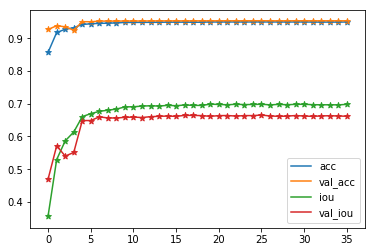

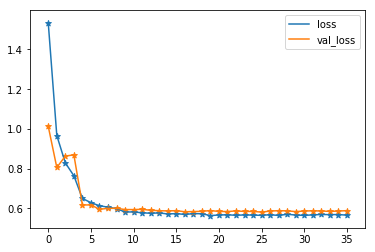

In [11]:
import matplotlib.pyplot as plt
plt.figure()
for metric in metric_list:
    plt.plot(result.epoch, result.history[metric], label=metric)
    plt.scatter(result.epoch, result.history[metric], marker='*')
    val_metric = 'val_' + metric
    plt.plot(result.epoch, result.history[val_metric], label=val_metric)
    plt.scatter(result.epoch, result.history[val_metric], marker='*')
plt.legend(loc='under right')
plt.show()

plt.figure()
plt.plot(result.epoch, result.history['loss'], label="loss")
plt.plot(result.epoch, result.history['val_loss'], label="val_loss")
plt.scatter(result.epoch, result.history['loss'], marker='*')
plt.scatter(result.epoch, result.history['val_loss'], marker='*')
plt.legend(loc='upper right')
plt.show()